In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2023-03-06 14:57:58.666162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:57:58.909397: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 14:57:58.967280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 14:57:58.967330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [114]:
data = pd.read_csv('data/processed/necklace_combined_old.csv')

In [115]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    98736
Running    98406
Stairs     61578
Sitting    14124
Falling    12672
Name: label, dtype: int64

In [116]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')

In [117]:
activities = data['label'].value_counts().index

In [118]:
activities

Index(['Walking', 'Running', 'Stairs', 'Sitting', 'Falling'], dtype='object')

In [119]:
def calculate_class_weights(y):
    import sklearn
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",
                                                    classes = np.unique(y),
                                                    y = y)
    class_weights = dict(zip(np.unique(y), class_weights))
    
    return class_weights

In [120]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [121]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [122]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,0.208260,0.448161,0.304220,0.083190,-0.688908,-0.253846,0
1,0.264339,0.432887,0.311919,0.073759,-0.681271,-0.242408,0
2,0.319605,0.393853,0.302020,0.062153,-0.674483,-0.248944,0
3,0.380560,0.393853,0.277822,0.032410,-0.750002,-0.253846,0
4,0.455332,0.266568,0.292121,-0.052465,-0.862007,-0.230969,0
...,...,...,...,...,...,...,...
285511,0.368369,-0.308761,0.502207,0.033861,-0.317254,0.651431,4
285512,0.370807,-0.356281,0.377915,0.109305,-0.211189,0.434099,4
285513,0.323669,-0.293487,0.402113,0.088993,0.030640,0.153038,4
285514,0.307414,-0.237481,0.480208,0.036763,0.269075,0.035385,4


### Frame Preparation 

In [123]:
import scipy.stats as stats

In [124]:
Fs = 33
frame_size = Fs*2
hop_size = Fs*2

In [125]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df), hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [126]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_6124/1045444072.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [127]:
scaled_X.shape

(285516, 7)

In [128]:
X.shape, y.shape

((4326, 66, 6), (4326,))

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 321, stratify = y)

In [130]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3893, 66, 6)
(3893,)
(433, 66, 6)
(433,)


In [131]:
X_train.shape, X_test.shape

((3893, 66, 6), (433, 66, 6))

In [132]:
counts = data['label'].value_counts()
counts

Walking    98736
Running    98406
Stairs     61578
Sitting    14124
Falling    12672
Name: label, dtype: int64

In [133]:
# calculate class_weight
class_weights = calculate_class_weights(y_train)

In [134]:
class_weights

{0: 4.500578034682081,
 1: 0.5801788375558867,
 2: 4.055208333333334,
 3: 0.9269047619047619,
 4: 0.5784546805349183}

In [135]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Models

In [136]:
def cnn_1d_model():
    model = Sequential()
    model.add(Conv1D(32, 3, activation = 'relu', input_shape = X_train[0].shape))
    # model.add(Dropout(0.2))
    # model.add(Conv1D(16, 5, activation = 'relu'))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model

In [137]:
def lstm_model():
    # X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
    # X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
    # X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

    model = Sequential()
    model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    return model


In [138]:
model = lstm_model()

In [140]:
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, mode = 'auto')
          
# compile model
model.compile(optimizer=Adam(learning_rate = 0.7), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])    

# train model
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 100, verbose=1, class_weight=class_weights, callbacks = [es])

Epoch 1/100
110/110 [==============================] - 33s 263ms/step - loss: 1.6988 - accuracy: 0.1784 - val_loss: 1.5161 - val_accuracy: 0.3359
Epoch 2/100
110/110 [==============================] - 28s 258ms/step - loss: 1.7020 - accuracy: 0.1462 - val_loss: 1.5630 - val_accuracy: 0.2179
Epoch 3/100
110/110 [==============================] - 28s 258ms/step - loss: 1.6584 - accuracy: 0.1627 - val_loss: 1.6777 - val_accuracy: 0.0410
Epoch 4/100
110/110 [==============================] - 23s 207ms/step - loss: 1.6962 - accuracy: 0.2132 - val_loss: 1.5513 - val_accuracy: 0.3718
Epoch 5/100
110/110 [==============================] - 26s 237ms/step - loss: 1.7173 - accuracy: 0.1499 - val_loss: 1.9465 - val_accuracy: 0.0333
Epoch 6/100
110/110 [==============================] - 27s 245ms/step - loss: 1.6718 - accuracy: 0.1767 - val_loss: 1.7357 - val_accuracy: 0.2179
Epoch 7/100
110/110 [==============================] - 28s 253ms/step - loss: 1.6936 - accuracy: 0.1756 - val_loss: 1.7864 -

### Evaluation

In [141]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

In [142]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

14/14 [==============================] - 2s 84ms/step


0.21478060046189376

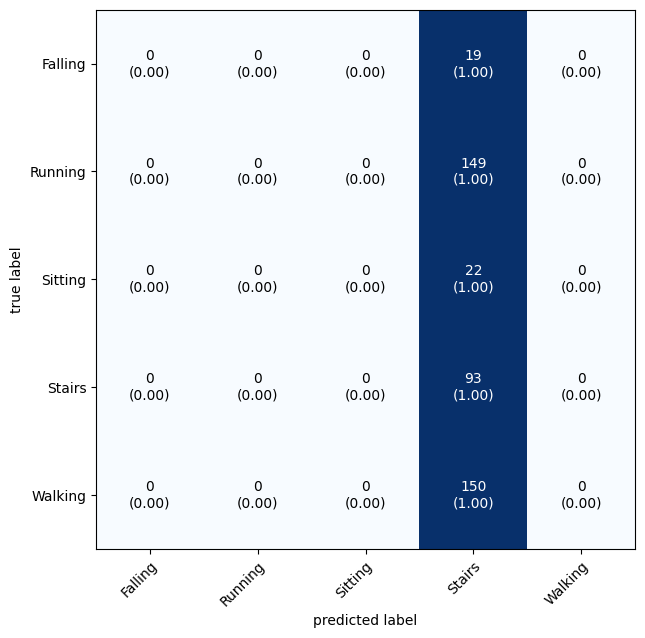

In [143]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)